In [2]:
import pandas as pd
import csv
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
% matplotlib inline

df_train = pd.read_csv("/Users/PatrickChen/Desktop/Capstone/train.csv")
df_test = pd.read_csv("/Users/PatrickChen/Desktop/Capstone/test.csv")

In [3]:
# Combine Train and Test
df1 = pd.concat([df_train,df_test],axis=0)
# df1 = df_train
df1 = df1.drop(["Id","SalePrice"], axis = 1)

In [4]:
df1.shape

(2919, 79)

# Changing Categories between numerical and categorical

In [5]:
# Numerical features that are actually categorical
df1.MSSubClass = df1.MSSubClass.astype(str)
df1.MoSold = df1.MoSold.astype(str)
df1.KitchenAbvGr = df1.KitchenAbvGr.astype(str)

In [6]:
# get data with categories
col = df1.dtypes[df1.dtypes == "object"].index
df_cat = df1[col]

# get data with numerical
col = df1.dtypes[df1.dtypes != "object"].index
df_num = df1[col]

In [7]:
# more than 50% of zeros should be changed to categorical

# stay as numerical
col = df_num.columns[(df_num == 0).sum(axis=0)/len(df_num)<0.5]
df_num_num = df_num[col]

# change to categorical
col = df_num.columns[(df_num == 0).sum(axis=0)/len(df_num)>0.5]
df_num_cat = df_num[col]

df_num_cat[df_num_cat != 0] = "Yes"
df_num_cat[df_num_cat!="Yes"] = "No"

/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/pandas/core/frame.py:2452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [8]:
# Combine Data
df1 = pd.concat([df_cat,df_num_num,df_num_cat],axis=1)

# Filling NULL Values

In [9]:
# Split features that contain nulls values
nulls = df1.columns[df1.isnull().sum()>0]
notnulls = df1.columns[df1.isnull().sum()==0]

df_nulls = df1[nulls]
df_notnulls = df1[notnulls]

In [10]:
# Split features by Categorical(Nulls) and Numerical(Nulls)

# get nulls with categories
col = df_nulls.dtypes[df_nulls.dtypes == "object"].index
df_cat = df_nulls[col]

# get nulls with numerical
col = df_nulls.dtypes[df_nulls.dtypes != "object"].index
df_num = df_nulls[col]

# Categorical Nulls

In [11]:
# Large number of missing should be filled with NONE
# Low number of missing should be filled with MOST common feature

# Split Categorical data from none and most
none = list(df_cat.isnull().sum()>df_cat.notnull().sum())
most = list(df_cat.isnull().sum()<df_cat.notnull().sum())
df_none = df_cat[df_cat.columns[none]]
df_most = df_cat[df_cat.columns[most]]

# fill nulls with none
df_none = df_none.fillna("None")

# fill nulls with Most common feature
df_most = df_most.fillna(df_most.mode().iloc[0])

# Numerical Nulls

In [12]:
# Numerical nulls should take on mean
df_num = df_num.fillna(df_num.mean())

Combine non-nulls and fixed nulls

In [13]:
# Combine all features together
df2 = pd.concat([df_notnulls,df_num,df_none,df_most],axis = 1)

# Eliminate outliers in Numerical Columns

In [14]:
# get numerical columns 
df_numerical = df2.columns[df2.dtypes!='object']

# #log transform skewed numeric features:
# skewed_feats = df2[df_numerical].apply(lambda x: skew(x))
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index
# df2[skewed_feats] = df2[skewed_feats]
# # df2[skewed_feats] = np.log1p(df2[skewed_feats])

In [15]:
# define plot function, and in this function, we will calculate the skew of X and take the log of y
# try and reduce graph size and add in TITLE. EDIT!!!! 
def plot_outlier(x):
    skew_value=skew(x)
    print x.name
    print('sample lengh: %s   and skew: %s'%(len(x),skew_value))
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    sns.boxplot(x,orient='v',ax=axs[0])
    sns.regplot(x,y,ax=axs[1])
    plt.tight_layout()
    plt.show()

In [16]:
# split data set from test to train before eliminate outlier 
df2_train, df2_test = df2.iloc[:1460,:], df2.iloc[1460:,:]

In [17]:
# Identify Outliers
df3= df2_train[
    (df2_train.LotArea<100000)
    &(df2_train.BsmtFinSF1<3000)
    &(df2_train.TotalBsmtSF<4000)
    &(df2_train["1stFlrSF"]<4000)
    &(df2_train.GrLivArea<4000)     #recommended
    &(df2_train.OpenPorchSF<450)
    &(df2_train.LotFrontage<300)]

In [18]:
# combine data after outlier
df4 = pd.concat([df3,df2_test],axis=0)

In [19]:
# get dummies for dataset
df4 = pd.get_dummies(df4)

In [20]:
# normalize dataset
df5 = np.log1p(df4)

# MODEL

SPLIT TEST AND TRAIN

In [21]:
# split data set from test to train
df3_train, df3_test = df5.iloc[:1448,:], df5.iloc[1448:,:]

In [22]:
# add in SalePrice
df3_train = df3_train.join(df_train.SalePrice, how = 'left', lsuffix='_x')

In [23]:
df3_train.shape

(1448, 334)

In [24]:
X = df3_train[df3_train.columns[df3_train.columns!="SalePrice"]]
y = np.log1p(df3_train.SalePrice)

In [25]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 10)

/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression() 
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#RMSE is the distance, on average, of a data point from the fitted line, measured along a vertical line.
# log is to normalize sale price
print "RMSE:", mean_squared_error(y_test,y_pred) #y_pred has negative number
print "r2", r2_score(y_test,y_pred) 



RMSE: 1.70424618988e+18
r2 -1.11465053424e+19


# Feature Selection

## Ridge

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
# prepare a range of alpha values to test
alphas = np.arange(4.0,5.0,0.1)

# create and fit a ridge regression model, testing each alpha
model = Ridge()
gs_ridge = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

# fit model
gs_ridge.fit(X_train, y_train)

# summarize the results of the grid search
print "best estimator", gs_ridge.best_estimator_
print "best params", gs_ridge.best_params_
print "best score", gs_ridge.best_score_

best estimator Ridge(alpha=4.3999999999999986, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
best params {'alpha': 4.3999999999999986}
best score 0.902505766327


In [29]:
y_pred = gs_ridge.predict(X_test)

#RMSE is the distance, on average, of a data point from the fitted line, measured along a vertical line.
# log is to normalize sale price
print "RMSE:", np.sqrt(mean_squared_error(y_test,y_pred))
print "r2", r2_score(y_test,y_pred) 


# Your submission scored 0.12545

RMSE: 0.107140040657
r2 0.924922464076


## Lasso

In [30]:
from sklearn.linear_model import Lasso

# prepare a range of alpha values to test
alphas = np.array([0.0009, 0.001,0.002])

# create and fit a ridge regression model, testing each alpha
model = Lasso()
gs_lasso = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

# fit model
gs_lasso.fit(X_train, y_train)

# summarize the results of the grid search
print "best estimator", gs_lasso.best_estimator_
print "best params", gs_lasso.best_params_
print "best score", gs_lasso.best_score_

best estimator Lasso(alpha=0.00089999999999999998, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
best params {'alpha': 0.00089999999999999998}
best score 0.906236122999


In [31]:
y_pred = gs_lasso.predict(X_test)

#RMSE is the distance, on average, of a data point from the fitted line, measured along a vertical line.
# log is to normalize sale price
print "RMSE:", np.sqrt(mean_squared_error(y_test,y_pred))
print "r2", r2_score(y_test,y_pred) 

# Your submission scored 0.12693

RMSE: 0.113856853253
r2 0.915213882192


# XGBoost

In [32]:
params = {
        'learning_rate': np.array([0.01,0.1,0.2]),
        'n_estimators':np.array([200,300]),
        'reg_lambda':np.array([5,6,7,8,9])
        }

In [33]:
from xgboost import XGBRegressor

# create and fit a ridge regression model, testing each alpha
model = XGBRegressor()
gs_XGB = GridSearchCV(model,params)

# fit model
gs_XGB.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([200, 300]), 'learning_rate': array([ 0.01,  0.1 ,  0.2 ]), 'reg_lambda': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
# # summarize the results of the grid search
print "best estimator", gs_XGB.best_estimator_
print "best params", gs_XGB.best_params_
print "best score", gs_XGB.best_score_

best estimator XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.10000000000000001, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=5,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best params {'n_estimators': 300, 'learning_rate': 0.10000000000000001, 'reg_lambda': 5}
best score 0.892113390405


In [35]:
# make predictions for test data
y_pred = gs_XGB.predict(X_test)

#RMSE is the distance, on average, of a data point from the fitted line, measured along a vertical line.
# log is to normalize sale price
print "RMSE:", np.sqrt(mean_squared_error(y_test,y_pred))
print "r2", r2_score(y_test,y_pred) 


# Your submission scored 0.13961

RMSE: 0.112732692901
r2 0.916879880401


# MODEL ANALYSIS

In [36]:
# model = Lasso(alpha=0.001)
model = Ridge(alpha=4.4)
# model = XGBRegressor()
model.fit(X,y)

Ridge(alpha=4.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [37]:
coef = pd.Series(model.coef_, index = X_train.columns)

In [38]:
print("Model picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Model picked 331 variables and eliminated the other 2 variables


In [39]:
pos_coef = pd.concat([coef.sort_values().tail(10)])
neg_coef = pd.concat([coef.sort_values().head(10)])

In [40]:
print pos_coef
print neg_coef

FullBath                0.095929
Neighborhood_NoRidge    0.096397
Neighborhood_Crawfor    0.104498
GarageCars              0.106752
Functional_Typ          0.109334
Neighborhood_StoneBr    0.124588
1stFlrSF                0.146282
OverallCond             0.200450
OverallQual             0.249503
GrLivArea               0.279233
dtype: float64
MSZoning_C (all)        -0.187457
Neighborhood_Edwards    -0.088209
Functional_Maj2         -0.085888
Neighborhood_MeadowV    -0.076990
Heating_Grav            -0.067507
Neighborhood_IDOTRR     -0.064219
SaleCondition_Abnorml   -0.064030
Condition1_RRAe         -0.063087
Neighborhood_OldTown    -0.057653
Foundation_BrkTil       -0.055783
dtype: float64


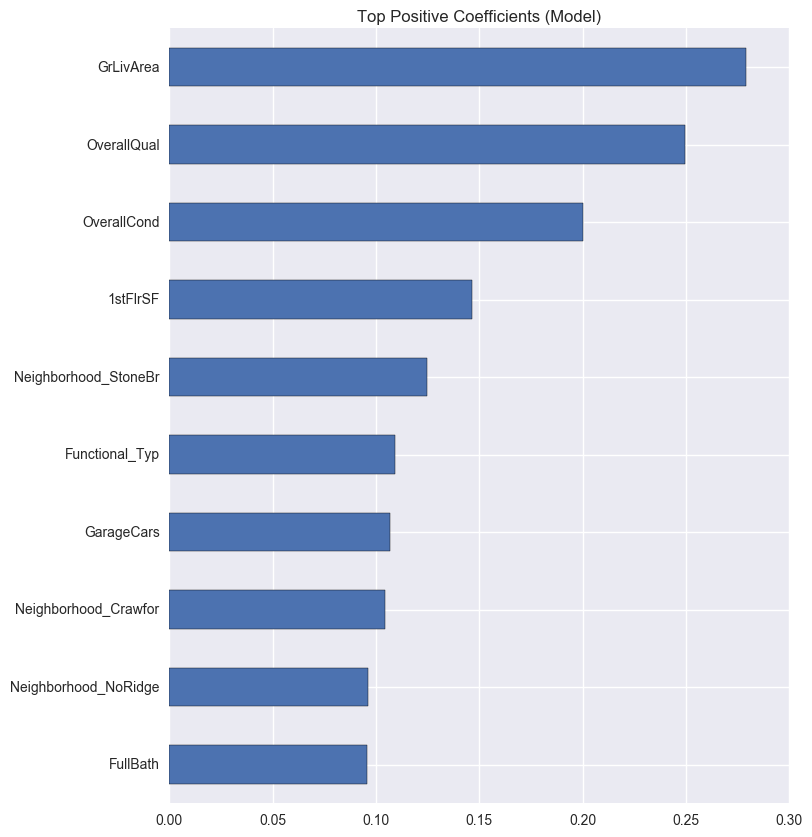

In [41]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
pos_coef.plot(kind = "barh")
plt.title("Top Positive Coefficients (Model)")
plt.show()

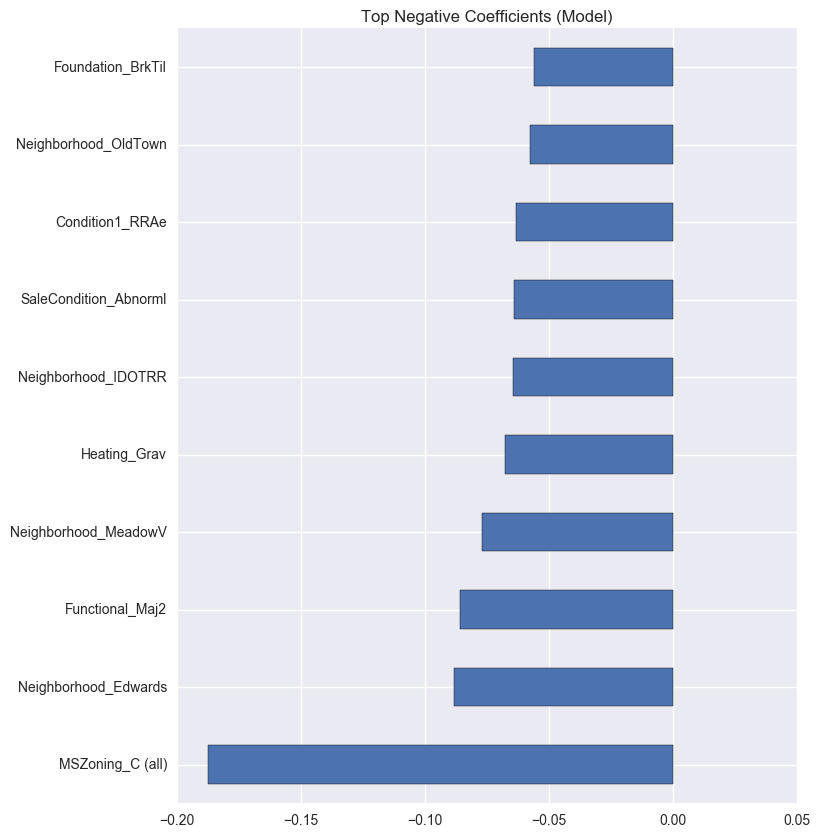

In [42]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
neg_coef.plot(kind = "barh")
plt.title("Top Negative Coefficients (Model)")
plt.show()

In [43]:
# change back to regular numbers
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

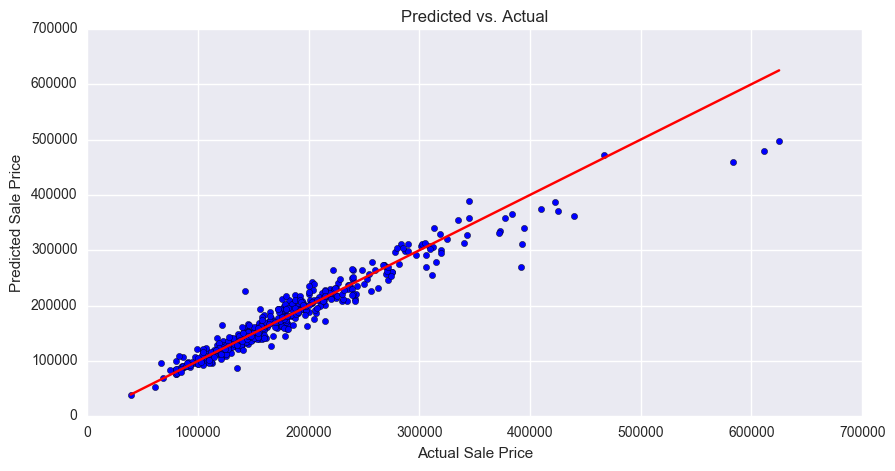

In [44]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],c="red")
plt.show()

# KAGGLE

In [45]:
# Kaggle Score 0.12162

In [46]:
# 1459 is needed
df3_test.shape

(1459, 333)

In [47]:
# Choose model to make predictions for test data
y_pred = model.predict(df3_test)
# get Id numbers from test set
df_kaggle = df_test.iloc[:,:1]

df_kaggle["SalePrice"] = np.expm1(pd.Series(y_pred))
df_kaggle.head()

,Id,SalePrice
0,1461,119826.123948
1,1462,165420.659489
2,1463,184948.413205
3,1464,199984.177747
4,1465,195757.268999


In [48]:
df_kaggle.to_csv("/Users/PatrickChen/Desktop/Capstone/submit.csv")